# 1. Credit Risk Modelling 

In this notebook , the credit risk dataset consisting of 32851 loan records to determine the best way to predict whether a loan applicant will fully repay or default on a loan. Here differnt machine learning models are tried
1. Random Forest
2. Catboost



As tthe dataset is unbalnced , these classifiers are tried after applying 
SMOTE, 
BorderLine SMOTE &
Oversmbling using Adaptive Synthetic Sampling (ADASYN). 

Out of all these variations Catboost with out SMOTE showed higher recall of all and random forest showed a stable performance with and with out smote. 

SO these two classifiers are selected as the final models for experimentaion.

 


## 1.1 Importing Libraries and loading the Dataset

In [1]:
#Importing LIbraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pylab as py

from sklearn.impute import SimpleImputer

 
import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
 
from sklearn.preprocessing import RobustScaler, PowerTransformer 

from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import  OneHotEncoder

from sklearn.model_selection import KFold, cross_val_score , train_test_split

from sklearn.ensemble import RandomForestClassifier,StackingClassifier
 
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Oversample imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
 
from imblearn.over_sampling import BorderlineSMOTE, SMOTE,ADASYN

from matplotlib import pyplot
from numpy import where

import pickle

import warnings
warnings.filterwarnings('ignore')

/home/yael/anaconda3/envs/risk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Function to Load data
def load_data(filename):
    df = pd.read_csv(filename)
    return df

In [3]:
#loading the dataset
df = load_data('../Data/credit_risk_dataset.csv')

# We are dropping some columns due to the column importance analysis 
df.drop(columns = ['cb_person_default_on_file','cb_person_cred_hist_length'], axis = 1, inplace =True)

#df_copy = df.copy(deep=True)

# 2. Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_age             32581 non-null  int64  
 1   person_income          32581 non-null  int64  
 2   person_home_ownership  32581 non-null  object 
 3   person_emp_length      31686 non-null  float64
 4   loan_intent            32581 non-null  object 
 5   loan_grade             32581 non-null  object 
 6   loan_amnt              32581 non-null  int64  
 7   loan_int_rate          29465 non-null  float64
 8   loan_status            32581 non-null  int64  
 9   loan_percent_income    32581 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 2.5+ MB


Out of total 32851 rows 'loan_int_rate' and 'person_emp_length' contains missing values.

There are 3 float variables, 5 integer variables and 4 object valriables there

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83


In [6]:
df.describe(include='object')

,person_home_ownership,loan_intent,loan_grade
count,32581,32581,32581
unique,4,6,7
top,RENT,EDUCATION,A
freq,16446,6453,10777


The number of catogeries in the four catogerical variables are not much high.
So can encode using one-hot encoding. 

Maximum people are taking loan for education. 

# 2.1 Checking Missing Vlaues

In [7]:
#Checking the number of missing values in each column
df.isnull().sum()

person_age                  0
person_income               0
person_home_ownership       0
person_emp_length         895
loan_intent                 0
loan_grade                  0
loan_amnt                   0
loan_int_rate            3116
loan_status                 0
loan_percent_income         0
dtype: int64

In [8]:
#percentage of null values in person_emp_length and loan_int_rate
(df.isnull().sum()/len(df))*100

person_age               0.000000
person_income            0.000000
person_home_ownership    0.000000
person_emp_length        2.747000
loan_intent              0.000000
loan_grade               0.000000
loan_amnt                0.000000
loan_int_rate            9.563856
loan_status              0.000000
loan_percent_income      0.000000
dtype: float64

Percantage of missing values in both the columns are under 30.

so can be treated with appropriate technique, after exploring the distribution etc 

# 2.2 Checking the  data distribution

In [9]:
# Function to display the distribution plot
def dist_plot(data, col):
     plt.figure()
     sns.histplot(data[col].dropna())
    

(None, None)

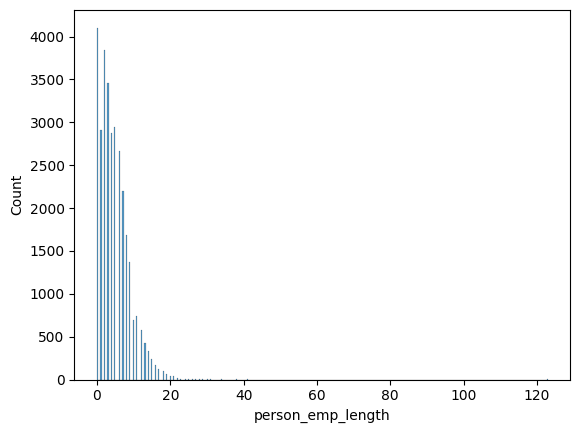

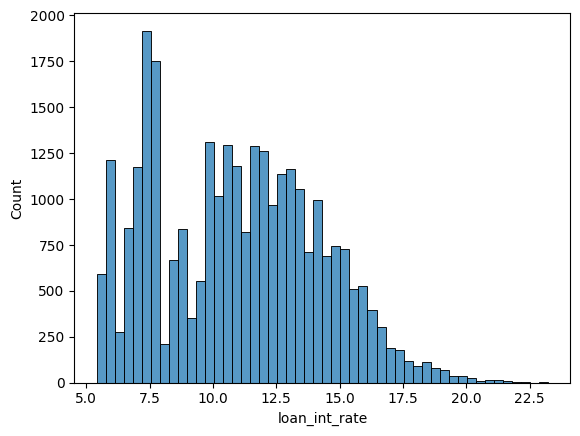

In [10]:
dist_plot(df,'person_emp_length'), dist_plot(df,'loan_int_rate')

Both are not following  a normal distribution. So preferably use 'median' to replace the missing values

Lets verify ith QQ plot

In [11]:
def qq_plot(data, col):
    sm.qqplot(data[col].dropna(), line ='45')
    py.show()

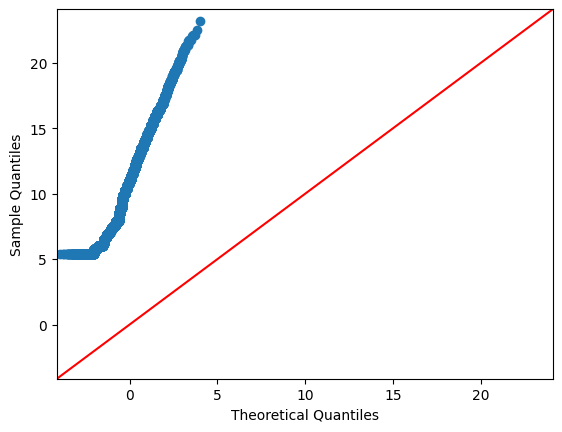

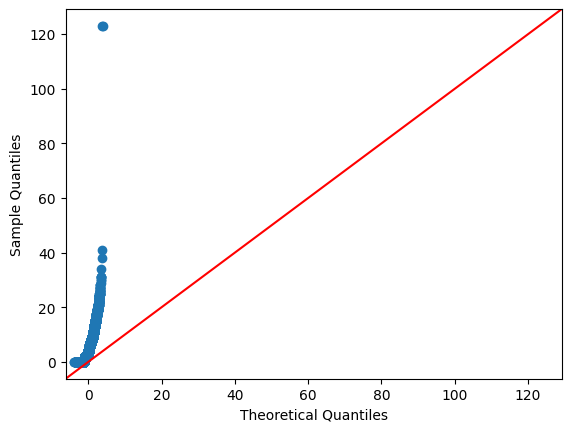

(None, None)

In [12]:
qq_plot(df, 'loan_int_rate'), qq_plot(df,'person_emp_length')

### Class distribution

In [13]:
#checking the percentage of each class
(df['loan_status'].value_counts()/len(df))*100

loan_status
0    78.183604
1    21.816396
Name: count, dtype: float64

Class imbalance is there

### DIstribution of data of each feature

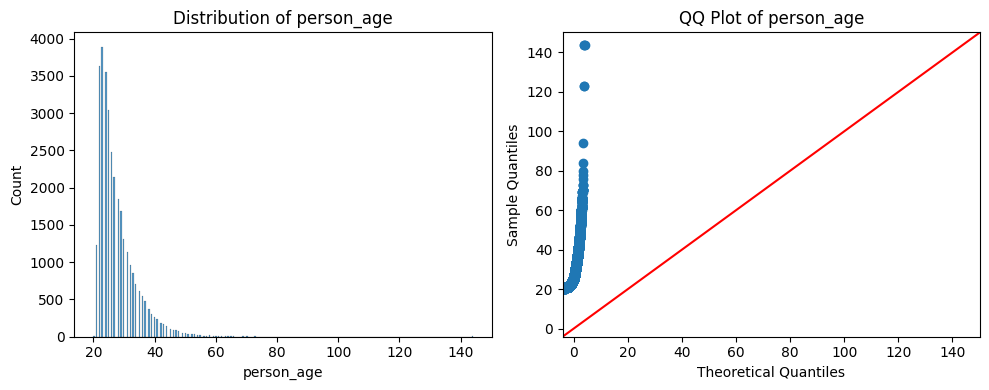

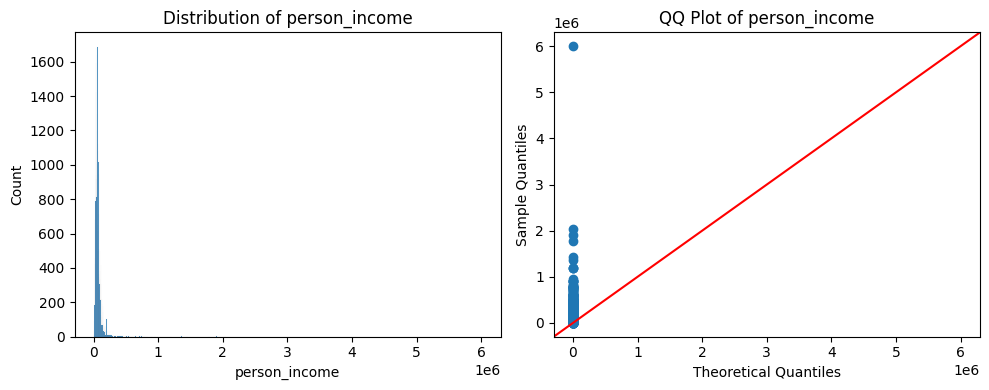

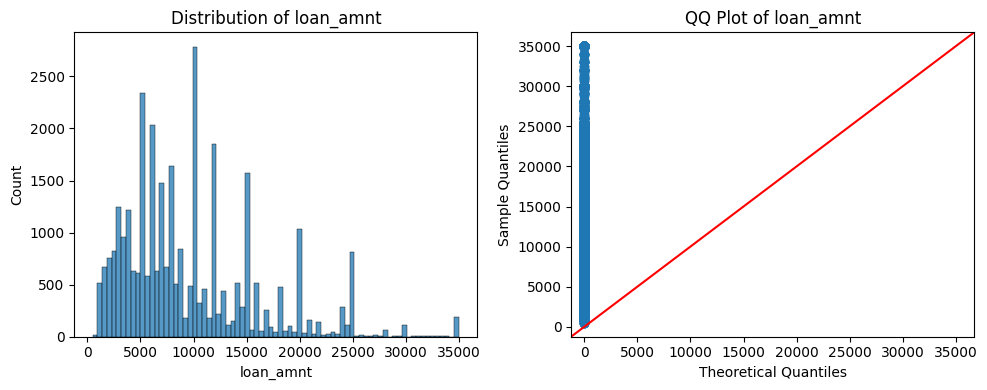

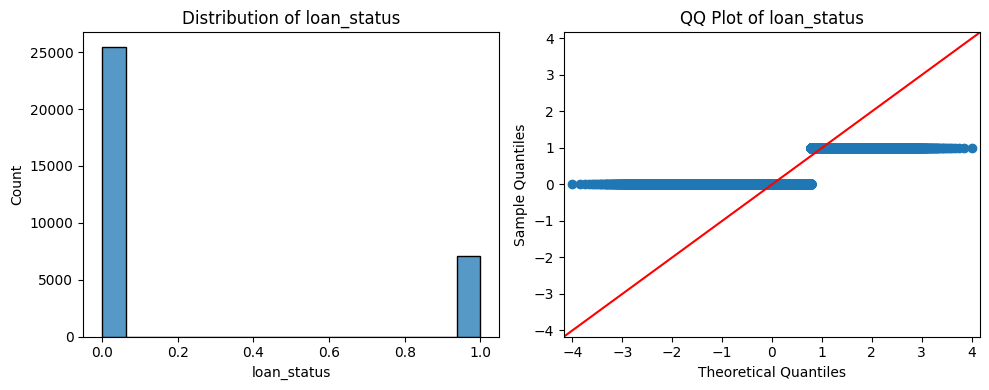

In [14]:
#create distplots of int
for column in df.select_dtypes(include='int64'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot distribution
    sns.histplot(df[column].dropna(), ax=axes[0])
    axes[0].set_title(f"Distribution of {column}")
    
    # Plot QQ plot
    sm.qqplot(df[column].dropna(), line='45', ax=axes[1])
    axes[1].set_title(f"QQ Plot of {column}")
    
    plt.tight_layout()
    plt.show()
    

person_age,

person_income,

loan_amount, 

cb_person_cred_hist_length

....all are somewhat right skewed distributions

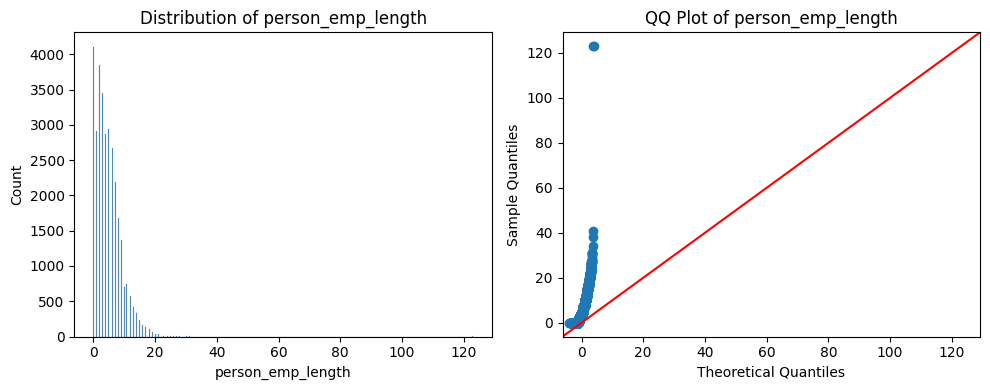

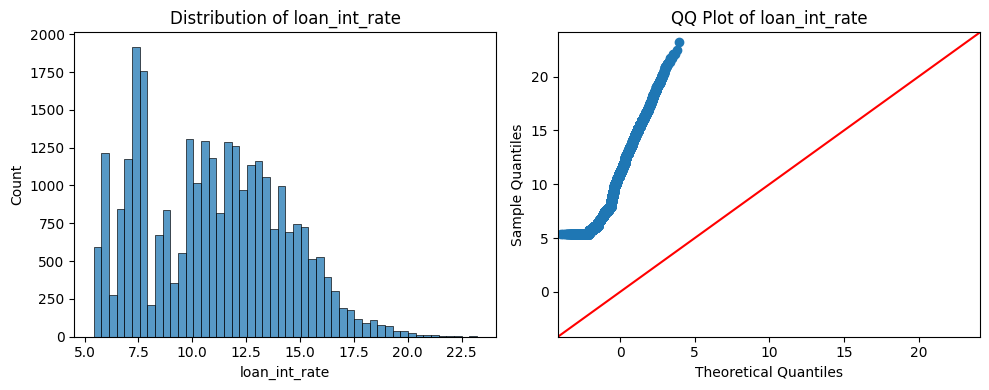

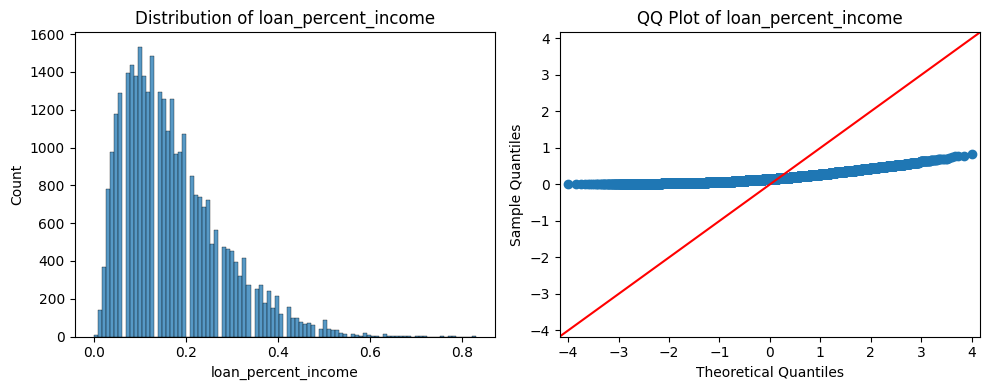

In [15]:
#create distplots of float
for column in df.select_dtypes(include='float'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot distribution
    sns.histplot(df[column].dropna(), ax=axes[0])
    axes[0].set_title(f"Distribution of {column}")
    
    # Plot QQ plot
    sm.qqplot(df[column].dropna(), line='45', ax=axes[1])
    axes[1].set_title(f"QQ Plot of {column}")
    
    plt.tight_layout()
    plt.show()

person_emp_length, 

loan_percent_income ----------are also right skewed


### Check the values in each feature

In [16]:
for column in df.select_dtypes(include='object'):
    print(df[column].value_counts())
    print("................................................")

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64
................................................
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64
................................................
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64
................................................


In [17]:
for column in df.select_dtypes(include='int64'):
    print(df[column].value_counts())
    print("................................................")

person_age
23     3889
22     3633
24     3549
25     3037
26     2477
27     2138
28     1854
29     1687
30     1316
21     1229
31     1142
32      964
33      856
34      709
35      620
36      548
37      478
38      373
39      302
40      271
41      241
42      188
43      164
44      141
45      108
46       94
47       94
48       75
50       52
49       49
51       39
52       36
53       30
54       24
55       20
58       19
56       15
57       15
20       15
60       15
65        9
66        9
61        9
70        7
64        7
62        7
59        5
69        5
144       3
73        3
63        3
123       2
78        1
94        1
80        1
84        1
76        1
67        1
Name: count, dtype: int64
................................................
person_income
60000    1046
30000     847
50000     778
40000     658
45000     590
         ... 
54316       1
54480       1
72645       1
72893       1
4888        1
Name: count, Length: 4295, dtype: int64
..........

In [18]:
for column in df.select_dtypes(include='float'):
    print(df[column].value_counts())
    print("................................................")

person_emp_length
0.0      4105
2.0      3849
3.0      3456
5.0      2946
1.0      2915
4.0      2874
6.0      2666
7.0      2196
8.0      1687
9.0      1367
11.0      740
10.0      696
12.0      575
13.0      426
14.0      335
15.0      238
16.0      165
17.0      129
18.0      104
19.0       64
20.0       42
21.0       38
22.0       19
24.0       10
23.0       10
25.0        8
26.0        6
27.0        5
31.0        4
28.0        3
123.0       2
30.0        2
41.0        1
34.0        1
29.0        1
38.0        1
Name: count, dtype: int64
................................................
loan_int_rate
7.51     756
10.99    749
7.49     645
7.88     642
5.42     594
        ... 
21.64      1
20.48      1
17.46      1
21.14      1
20.53      1
Name: count, Length: 348, dtype: int64
................................................
loan_percent_income
0.10    1533
0.13    1482
0.08    1437
0.07    1394
0.11    1381
        ... 
0.62       1
0.76       1
0.83       1
0.72       1
0.78    

Except loan status (which is the target variable) all int and float columns are continuous values

NO catogerical value encoded as 'int'

## 2.3 Checking the correlation between features and target

In [19]:
import pandas as pd

def one_hot_encode(data):
    """
    One-hot encodes object-type columns in the DataFrame.
    """
    return pd.get_dummies(data, drop_first=True,dtype='int64')

def get_corr(data, col):
    """
    Calculates the Spearman correlation for the specified column after
    encoding object-type columns using One-Hot Encoding.
    """
    # One-hot encode object columns
    encoded_data = one_hot_encode(data)
    
    # Compute correlation
    if col in encoded_data.columns:
        cor = encoded_data.corr(method='spearman')[col].sort_values(ascending=False)
        print(cor)
    else:
        print(f"Column '{col}' not found in the dataset after encoding.")


In [20]:
data = one_hot_encode(df)

In [21]:
get_corr(df,'loan_status')

loan_status                    1.000000
loan_int_rate                  0.320062
loan_grade_D                   0.318998
loan_percent_income            0.316115
person_home_ownership_RENT     0.238430
loan_grade_E                   0.180122
loan_grade_F                   0.101841
loan_amnt                      0.084032
loan_grade_G                   0.082306
loan_intent_MEDICAL            0.056595
loan_intent_HOMEIMPROVEMENT    0.036607
person_home_ownership_OTHER    0.012543
loan_grade_C                  -0.013031
loan_intent_PERSONAL          -0.021094
person_age                    -0.033354
loan_intent_EDUCATION         -0.055348
loan_intent_VENTURE           -0.078274
loan_grade_B                  -0.092190
person_emp_length             -0.097558
person_home_ownership_OWN     -0.101960
person_income                 -0.272131
Name: loan_status, dtype: float64


Correlation between features are target are not very high

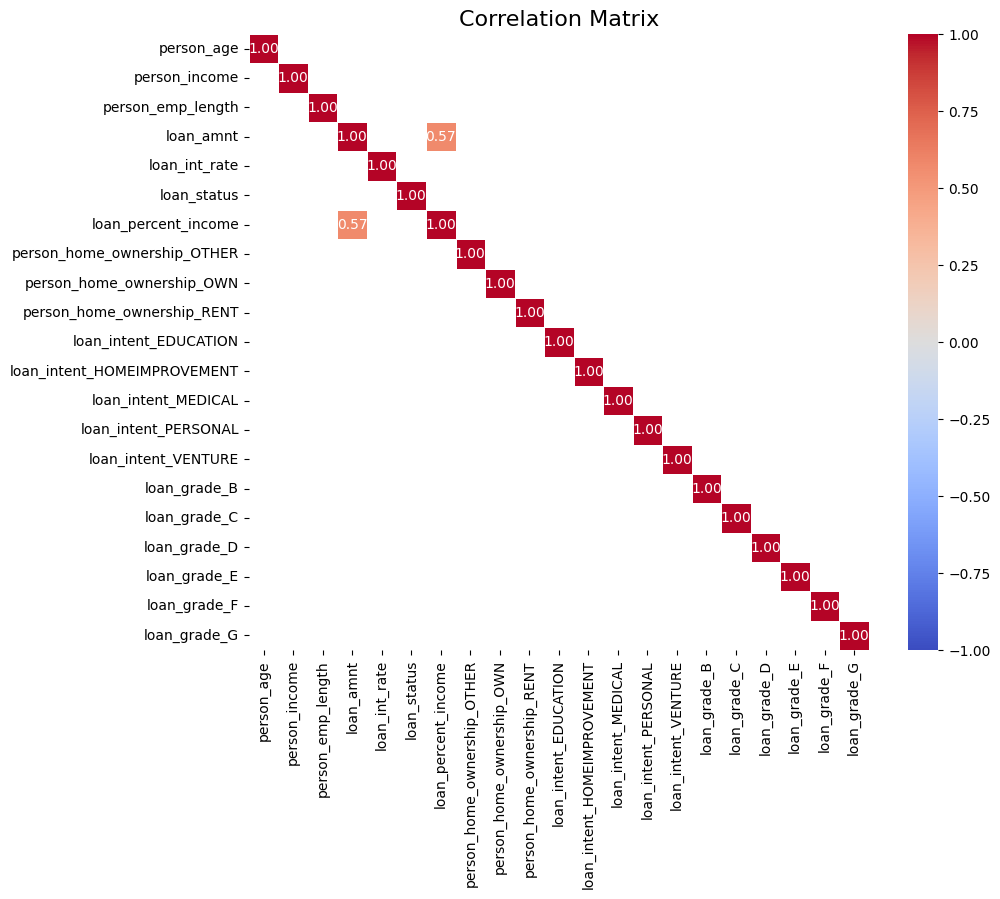

In [22]:
cor = data.corr()
cor = cor[((cor >= .5) | (cor<= -.5))]
plt.figure(figsize=(10, 8))
sns.heatmap(
    cor, 
    annot=True,  # Show correlation values
    fmt=".2f",   # Format for values
    cmap="coolwarm",  # Color scheme
    vmin=-1, vmax=1,  # Scale range
    cbar=True,  # Show color bar
    linewidths=0.5  # Line between cells
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

loan_amnt -->  loan_percent_income    ----       0.572612


person_age  --> cb_person_cred_hist_length   ---- 0.859133


Very high correlation between person_age  &  cb_person_cred_hist_length 

## 2.4 Checking if Multicollinearity exists in the dataset

In [23]:
#function to check multicolliearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [24]:
X = df.select_dtypes(exclude='object').dropna() 
calc_vif(X)

,variables,VIF
0,person_age,11.463033
1,person_income,3.157154
2,person_emp_length,2.449973
3,loan_amnt,7.147727
4,loan_int_rate,9.941021
5,loan_status,1.655651
6,loan_percent_income,7.684559


Age has high value for VIF, which indicates that it can be predicted by other independent variables in the dataset.

SO the column 'age' can be dropped ifants to reduce the feature set

# 3. Data Transformation 

### Train Test Split


In [25]:
target = 'loan_status'
median_list = ['loan_int_rate','person_emp_length']
mean_list = []
log_list = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate','loan_percent_income']
random_seed = 42
test_size =0.3 
label_encode =True
#is_train=True
catogerical_columns = [col for col in df.columns if df[col].dtype=="O"]

In [26]:
df['loan_status'].value_counts()/len(df)

loan_status
0    0.781836
1    0.218164
Name: count, dtype: float64

In [27]:
def Train_Test_Split(data, target):
    X= data.drop(target, axis =1)
    y= data[target]    
       
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=test_size, random_state=random_seed)
    return X_train, X_test,y_train,y_test

In [28]:
#Before doing the data transfoamtion lets do the train tets split to avoid data leakage
X_train, X_test,y_train,y_test=Train_Test_Split(df,target)

In [29]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape )

(22806, 9) (22806,) (9775, 9) (9775,)


### Defining Preprocessor : <br>Missing Value Imputation,Power Transformation,Label Encoding 

In [30]:
# Imputing nulls and power transform for numeric columns
num_imputer = SimpleImputer(strategy='median')
power_transformer=   PowerTransformer()
 
# Imputing nulls through the encoding for categorical columns
encoder = OneHotEncoder(handle_unknown="ignore")

# Defining different transformers for numeric and categorical columns
num_transformer = make_pipeline(num_imputer)
pow_transformer = make_pipeline(num_transformer,power_transformer)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, median_list),
                    ('power',pow_transformer,log_list),
                    ('cat', cat_transformer, catogerical_columns)])

# 4. Catboost Classifier

In [31]:
# choosing model
model_name = cat.CatBoostClassifier(iterations=500, verbose=100,eval_metric="Recall")

# giving all values to pipeline
catboost_pipe = make_pipeline(preprocessor,model_name)


#Training the model
catboost_pipe.fit(X_train,y_train)

# predicting using trained model 
y_true = y_test
y_pred = catboost_pipe.predict(X_test)
print('Catboost_model: recall:', recall_score(y_true, y_pred))
print('Catboost_model: precision:',precision_score(y_true, y_pred))
print('catboost_model: F1 Score:', f1_score(y_true, y_pred))
print('Catboost_model: accuracy:', accuracy_score(y_true, y_pred))


# exporting the model 
pickle.dump(catboost_pipe,open('catboost_model.pkl','wb'))
# load model
with open('catboost_model.pkl', 'rb') as f:
    loaded_classifier_catboost = pickle.load(f)

Learning rate set to 0.073938
0:	learn: 0.5153660	total: 57.2ms	remaining: 28.5s
100:	learn: 0.7221998	total: 970ms	remaining: 3.83s
200:	learn: 0.7327133	total: 1.87s	remaining: 2.78s
300:	learn: 0.7476749	total: 2.81s	remaining: 1.86s
400:	learn: 0.7591994	total: 3.73s	remaining: 921ms
499:	learn: 0.7699151	total: 4.68s	remaining: 0us
Catboost_model: recall: 0.7312673450508789
Catboost_model: precision: 0.9657910812461821
catboost_model: F1 Score: 0.8323242958673335
Catboost_model: accuracy: 0.9348337595907928


# 5. Feature Importance

In [32]:
# from sklearn.inspection import permutation_importance
# result = permutation_importance(catboost_pipe, X_test, y_test,
#                            n_repeats=30,
#                            random_state=0)
# sorted_importances_idx = result.importances_mean.argsort()
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=X_test.columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

# 6. Repeat the pipeline after dropping the two columns with least importance

In [33]:
# # choosing model
# model_name = cat.CatBoostClassifier(iterations=500, verbose=100,eval_metric="Recall")

# # giving all values to pipeline
# catboost_pipe_new = make_pipeline(preprocessor,model_name)

# catboost_pipe_new.fit(X_train,y_train)

# # predict
# y_true = y_test
# y_pred = catboost_pipe_new.predict(X_test)
# print('Catboost_model: recall:', recall_score(y_true, y_pred))
# print('Catboost_model: precision:',precision_score(y_true, y_pred))
# print('catboost_model: F1 Score:', f1_score(y_true, y_pred))
# print('Catboost_model: accuracy:', accuracy_score(y_true, y_pred))

# path_export = '../Data/models/catboost/saved_models/catboost.pkl',
# pickle.dump(catboost_pipe_new,open(path_export,'wb'))

# Shap 

In [34]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

import shap

shap.initjs()



In [35]:
X_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income
12657,25,66300,MORTGAGE,9.0,MEDICAL,A,1700,6.76,0.02
11611,22,75000,MORTGAGE,6.0,MEDICAL,B,25000,9.25,0.33
18223,31,105400,RENT,2.0,MEDICAL,D,24250,15.31,0.20
24772,35,75000,MORTGAGE,5.0,PERSONAL,B,5000,8.70,0.07
30770,36,65000,MORTGAGE,6.0,EDUCATION,C,23325,15.27,0.36
...,...,...,...,...,...,...,...,...,...
29802,39,38500,MORTGAGE,7.0,MEDICAL,C,3500,13.98,0.09
5390,25,69000,RENT,5.0,HOMEIMPROVEMENT,A,8500,6.92,0.12
860,26,148000,RENT,1.0,DEBTCONSOLIDATION,E,20000,17.99,0.14
15795,26,175000,MORTGAGE,0.0,PERSONAL,C,15000,NaN,0.09


In [36]:
X_processed= one_hot_encode(X_train)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_processed, y_train, verbose=False, plot=False)

y_true = y_test
y_pred = model.predict(one_hot_encode(X_test))

##TODO print many metrics 
print('Catboost_model: MSE:', mean_squared_error(y_true, y_pred))



Catboost_model: MSE: 0.057732458098612965


In [38]:
# Apply threshold to convert continuous targets to binary
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Performance:
Accuracy: 0.9345268542199489
Precision: 0.9828680203045685
Recall: 0.7164662349676225
F1 Score: 0.8287854467629748


In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_processed)

# visualize the first prediction's explanation
shap.plots.force(shap_values[0, ...])


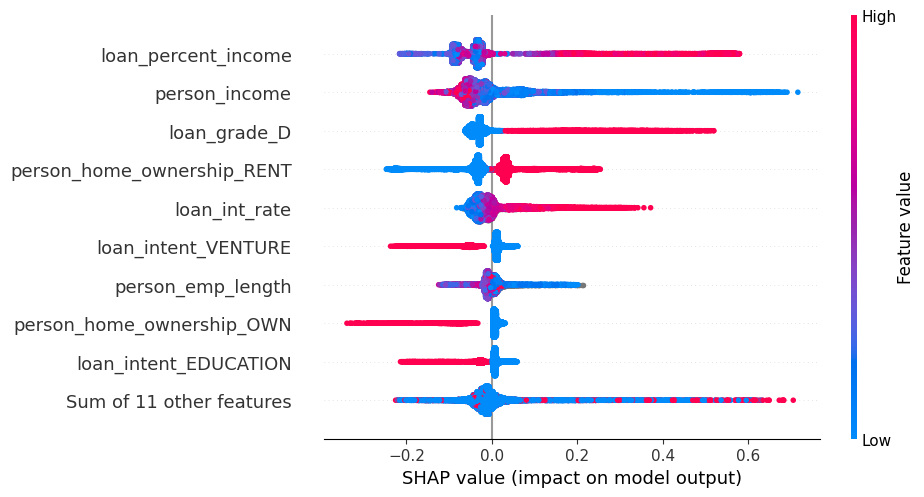

In [40]:
shap.plots.beeswarm(shap_values)

In [41]:
# # visualize the training set predictions
# shap.plots.force(shap_values)

In [46]:
X_processed

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
12657,25,66300,9.0,1700,6.76,0.02,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11611,22,75000,6.0,25000,9.25,0.33,0,0,0,0,0,1,0,0,1,0,0,0,0,0
18223,31,105400,2.0,24250,15.31,0.20,0,0,1,0,0,1,0,0,0,0,1,0,0,0
24772,35,75000,5.0,5000,8.70,0.07,0,0,0,0,0,0,1,0,1,0,0,0,0,0
30770,36,65000,6.0,23325,15.27,0.36,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,39,38500,7.0,3500,13.98,0.09,0,0,0,0,0,1,0,0,0,1,0,0,0,0
5390,25,69000,5.0,8500,6.92,0.12,0,0,1,0,1,0,0,0,0,0,0,0,0,0
860,26,148000,1.0,20000,17.99,0.14,0,0,1,0,0,0,0,0,0,0,0,1,0,0
15795,26,175000,0.0,15000,NaN,0.09,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [45]:
shap.dependence_plot("loan_int_rate", shap_values.values, X_processed, interaction_index="loan_in_rate")

ValueError: Could not find feature named: loan_in_rate